# Supervised Learning Notebook
* This notebook runs **three** different **supervised learning algorithms** (*Random Forest, Gradient Boost, and KNeighbor*) and will output the correponding classification report, confusion matrix, ROC curve, and the feature importance plot. 

* We make use of **pipelines** to streamline the tasks in this notebook. GridsearchCV is used to find optimal parameters for each of the algorithms used. 

* At the end we **identify and output the best performing supervised learning algorithm** based on the *accuracy score*. 




## Model Selection Basis
![sklearn_map](map.png)

## Dataset Feild Descriptions

**HST:** Host Hotels & Resorts, Inc. is an S&P 500 company and is the largest lodging real estate investment trust and one of the largest owners of luxury and upper-upscale hotels. 

**XTN:** The S&P Transportation Select Industry Index (the “Index”) represents the transportation segment of the S&P Total Market Index (“S&P TMI”).

**Interest Score:** Google search trends on COVID

**Sentiment:** Twiter sentiment based on usage of the "COVID" word for the day. REesults are obtained by applying VADER sentiment analysis to 1000 tweats per day.

**Total_cases:** Total COVID cases since inception. 

**New_cases:** Number of new cases reported for the day.

**Total_deaths:** Total deaths since inception. 

**New_deaths:** Number of new deaths reported for the day. 

**S&P 500 Daily Movement:** This is the daily percentchange of the S&P index. 


## External Library
This notebook uses the lightgbm framework to perform the gradiant boosting classification. You may install it using the following command:

```!pip install lightgbm```


### Import Libraries

In [213]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [214]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve

### Loading and Preprocessing Dataset

In [215]:
# Read in the data
df = pd.read_csv('supervised_no_pca.csv', index_col=None)

In [216]:
df

,Unnamed: 0,Interest Score,HST,XTN,sentiment,total_cases,new_cases,total_deaths,new_deaths,S&P 500 Daily Movement
0,2020-03-03,7,-0.053440,-0.028093,neutral,74.0,19.0,7.0,1.0,neg
1,2020-03-04,7,0.007057,0.031684,neutral,107.0,33.0,11.0,4.0,pos
2,2020-03-05,7,-0.078486,-0.065194,neutral,184.0,77.0,12.0,1.0,neg
3,2020-03-06,7,0.023574,-0.005379,neutral,237.0,53.0,14.0,2.0,neg
4,2020-03-09,30,-0.103269,-0.085571,neutral,594.0,75.0,22.0,1.0,neg
...,...,...,...,...,...,...,...,...,...,...
245,2021-02-22,70,-0.002987,0.011670,neutral,28233518.0,56159.0,502465.0,1325.0,neg
246,2021-02-23,70,-0.005992,0.006627,negative,28305788.0,72270.0,504747.0,2282.0,pos
247,2021-02-24,70,0.031947,0.016336,neutral,28380537.0,74749.0,507916.0,3169.0,pos
248,2021-02-25,70,-0.044393,-0.023630,neutral,28458041.0,77504.0,510366.0,2450.0,neg


In [217]:
# Properly name the date column 
df = df.rename(columns={'Unnamed: 0':'date'})

In [218]:
# Set the date column as the index 
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)

In [219]:
# Convert categorical data to numeric 
df= pd.get_dummies(df, columns=['sentiment'])

In [220]:
# Setup our label column 
df['label'] = np.where(df["S&P 500 Daily Movement"].str.contains('neg'), -1, 1)
df = df.drop(columns='S&P 500 Daily Movement')

### Final Dataframe

In [221]:
df

,Interest Score,HST,XTN,total_cases,new_cases,total_deaths,new_deaths,sentiment_negative,sentiment_neutral,sentiment_positive,label
date,,,,,,,,,,,
2020-03-03,7,-0.053440,-0.028093,74.0,19.0,7.0,1.0,0,1,0,-1
2020-03-04,7,0.007057,0.031684,107.0,33.0,11.0,4.0,0,1,0,1
2020-03-05,7,-0.078486,-0.065194,184.0,77.0,12.0,1.0,0,1,0,-1
2020-03-06,7,0.023574,-0.005379,237.0,53.0,14.0,2.0,0,1,0,-1
2020-03-09,30,-0.103269,-0.085571,594.0,75.0,22.0,1.0,0,1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,70,-0.002987,0.011670,28233518.0,56159.0,502465.0,1325.0,0,1,0,-1
2021-02-23,70,-0.005992,0.006627,28305788.0,72270.0,504747.0,2282.0,1,0,0,1
2021-02-24,70,0.031947,0.016336,28380537.0,74749.0,507916.0,3169.0,0,1,0,1


### Summerizing and Visualizing the Dataset 

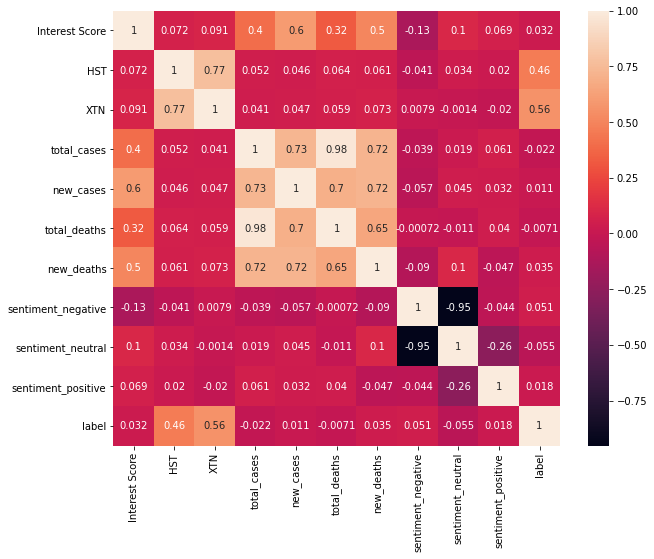

In [222]:
# Plot the correlation matrix
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(10,8))  
sns.heatmap(corrMatrix, annot=True, ax=ax);

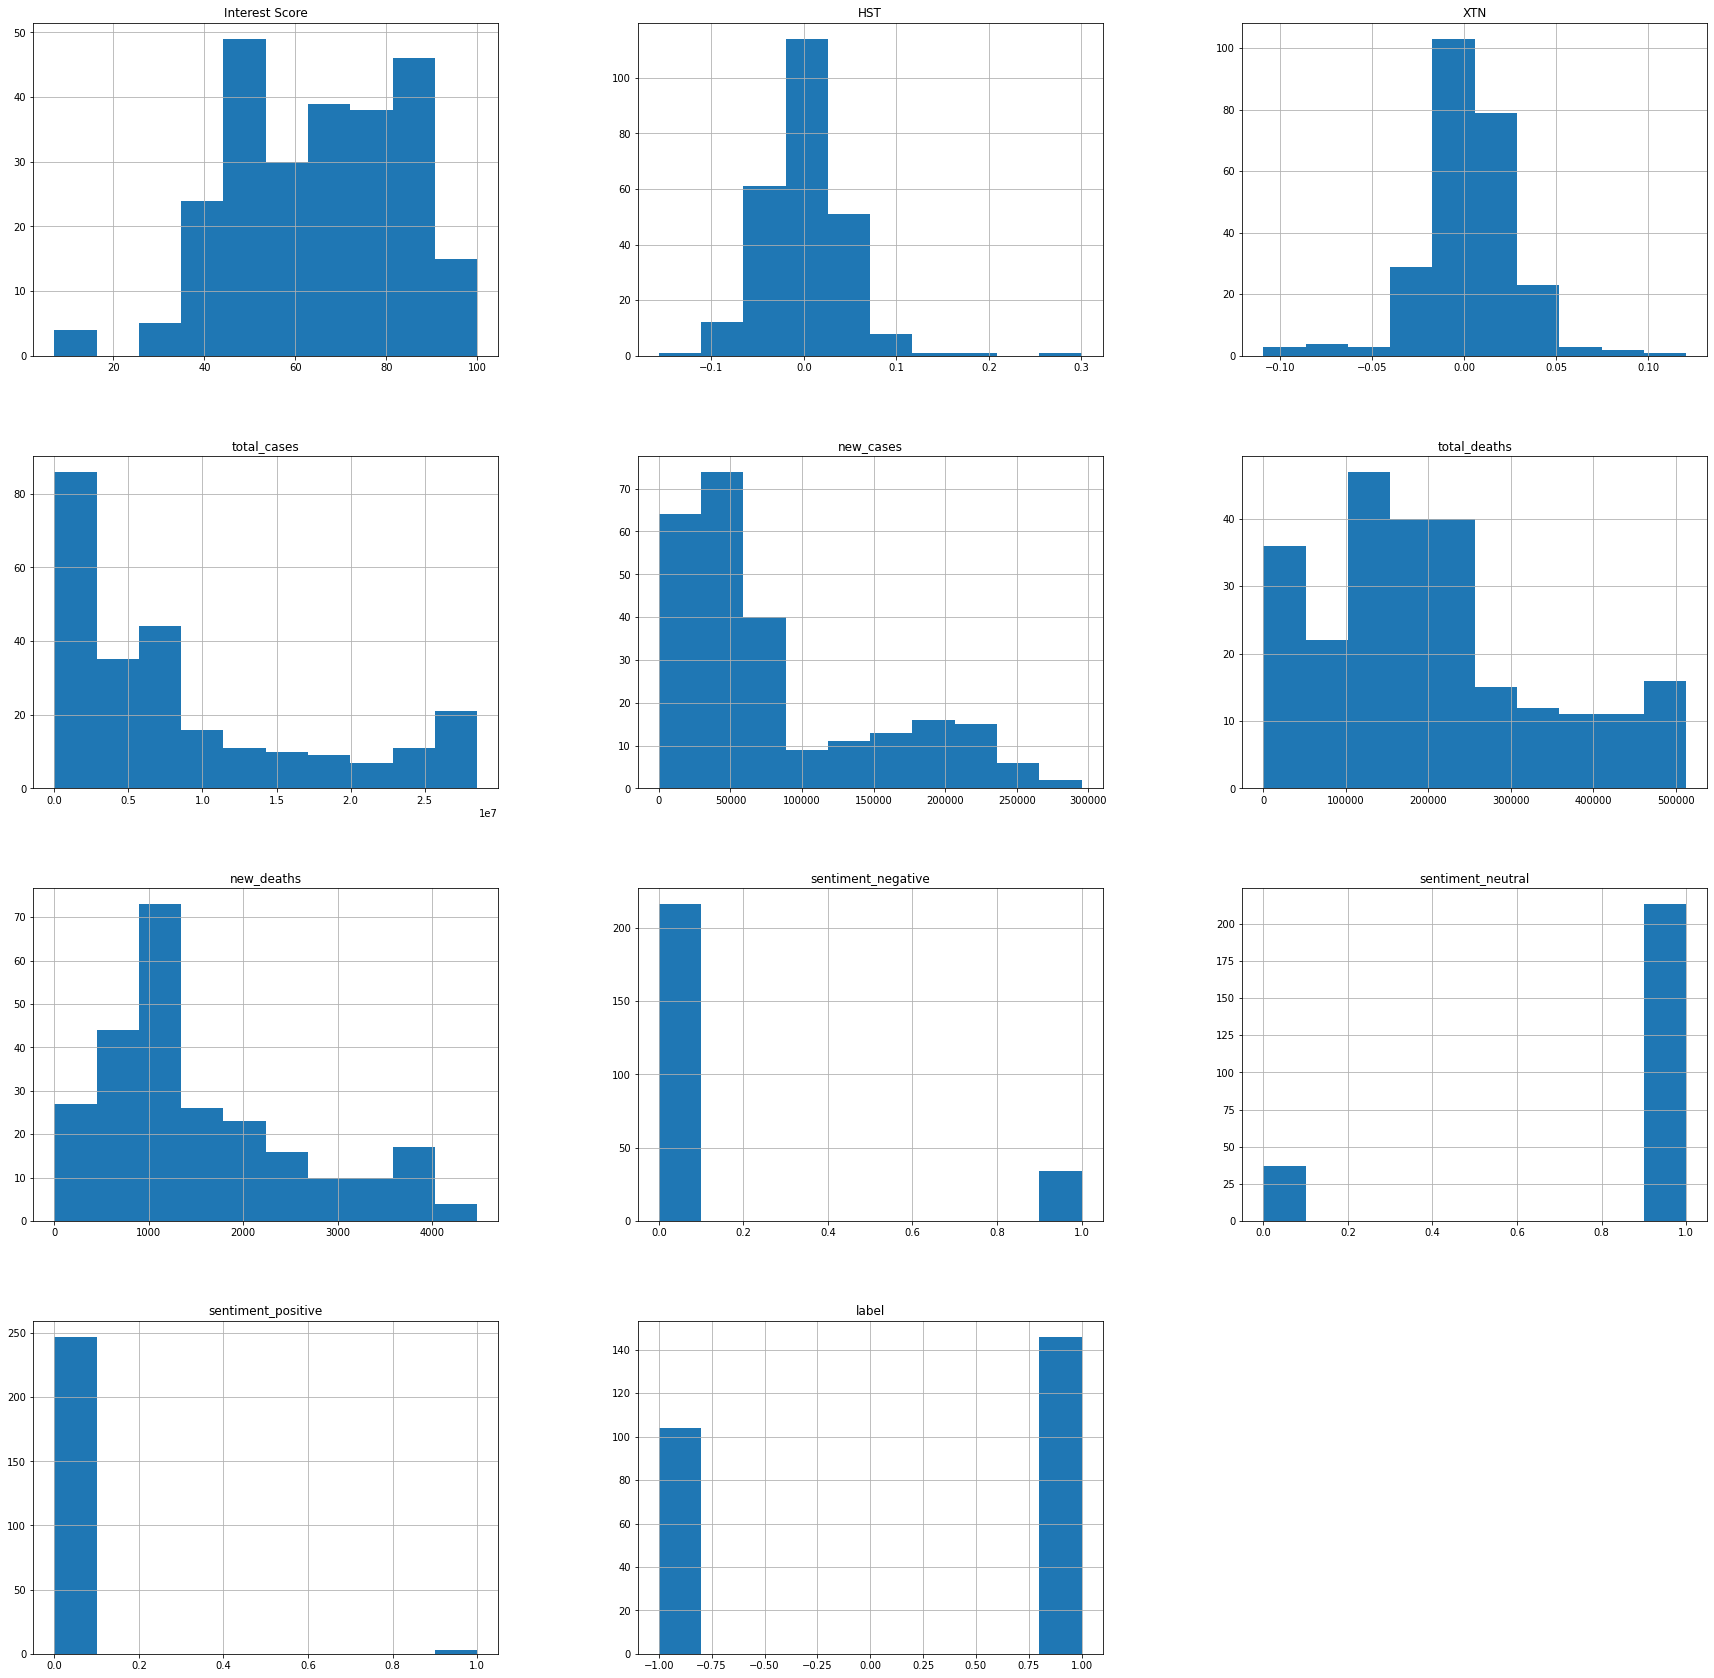

In [223]:
df.hist(figsize=(30, 30))
plt.show()

### AUX Functions

In [224]:
def plot_feature_importance(importance,names,model_type):
    """Visualize the feature importance array that is generated by a model

    Parameters
    ----------
        importance: this is the feature_importance property of the model

        names: a list of feature names
        
        model_type: name of the model

    Returns
    ----------
        None: This function does not return any value.

    """
    #Convert feature importance and feature names into array
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    feature_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    feature_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Plot bar chart
    sns.barplot(x=feature_df['feature_importance'], y=feature_df['feature_names'])
  
    #Set labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

### Modeling, Evaluation, and Prediction

In [225]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=0.30, random_state=101)

In [226]:
# Create pipelines 
pipe_rf = Pipeline(steps=[('scl', StandardScaler()), ('clf', RandomForestClassifier())])

pipe_kn = Pipeline(steps=[('scl', StandardScaler()), ('clf', KNeighborsClassifier())])

pipe_gb = Pipeline(steps=[('scl', StandardScaler()), ('clf', LGBMClassifier())])


In [227]:
# Set GridSearchCV Parameters
grid_params_rf = [{"clf__n_estimators": [10, 100, 200],
           "clf__max_depth": [None, 3, 5],
           "clf__min_samples_split": [2, 8, 10],
           "clf__min_samples_leaf": [2, 4, 8]}]

grid_params_gb = [{
    'clf__n_estimators': [400, 700, 1000],
    'clf__colsample_bytree': [0.7, 0.8],
    'clf__max_depth': [15,20,25],
    'clf__num_leaves': [50, 100, 200],
    'clf__reg_alpha': [1.1, 1.2, 1.3],
    'clf__reg_lambda': [1.1, 1.2, 1.3],
    'clf__min_split_gain': [0.3, 0.4],
    'clf__subsample': [0.7, 0.8, 0.9],
    'clf__subsample_freq': [20]
}]
                   
grid_params_kn = [{
    'clf__n_neighbors': [1,10],
    'clf__leaf_size': [20,40],
    'clf__p': [1,2],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']}]

In [228]:
# Construct GridSearchCV for each pipeline

jobs = -1

gs_rf = GridSearchCV(pipe_rf, 
            param_grid=grid_params_rf,
            scoring='accuracy',
            cv=10, 
            n_jobs=jobs)


gs_gb = GridSearchCV(pipe_gb, 
            param_grid=grid_params_gb,
            scoring='accuracy',
            cv=10, 
            n_jobs=jobs)

gs_kn = GridSearchCV(pipe_kn, 
            param_grid=grid_params_kn,
            scoring='accuracy',
            cv=10, 
            n_jobs=jobs)

In [229]:
# List of pipelines to iterate through
grids = [gs_rf, gs_kn, gs_gb]

In [230]:
# Dictionary of classifier types for printing 
grid_dict = {0: 'Random Forest', 1: 'KNeighbor', 2: 'Gradient Boost'}

Performing model optimizations...

Estimator: Random Forest
Best params: {'clf__max_depth': 5, 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}
Best training accuracy: 0.834
Test set accuracy score for best params: 0.760 


- Classification Report -

              precision    recall  f1-score   support

          -1       0.71      0.76      0.74        33
           1       0.80      0.76      0.78        42

    accuracy                           0.76        75
   macro avg       0.76      0.76      0.76        75
weighted avg       0.76      0.76      0.76        75



- Confusion Matrix -



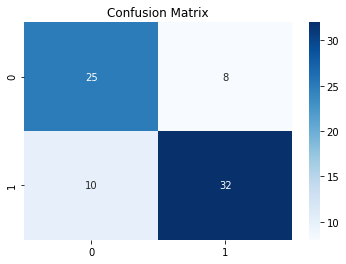



- ROC/AUC -



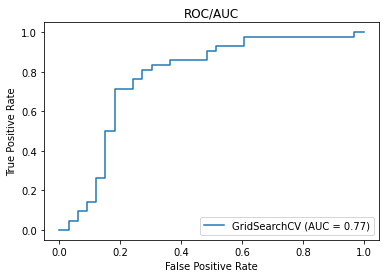



- Feature Importance -



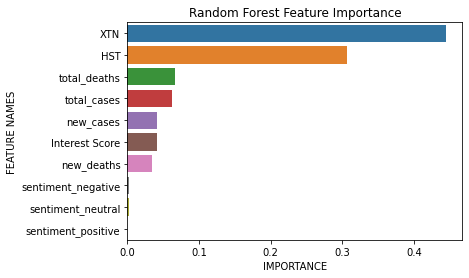

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

Estimator: KNeighbor
Best params: {'clf__leaf_size': 20, 'clf__metric': 'euclidean', 'clf__n_neighbors': 10, 'clf__p': 1, 'clf__weights': 'distance'}
Best training accuracy: 0.788
Test set accuracy score for best params: 0.733 


- Classification Report -

              precision    recall  f1-score   support

          -1       0.72      0.64      0.68        33
           1       0.74      0.81      0.77        42

    accuracy                           0.73        75
   macro avg       0.73      0.72      0.73        75
weighted avg       0.73      0.73      0.73        75



- Confusion Matrix -



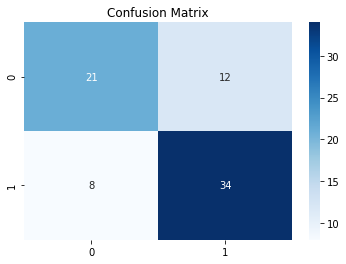



- ROC/AUC -



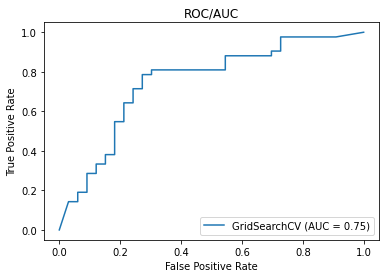

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

Estimator: Gradiant Boost
Best params: {'clf__colsample_bytree': 0.7, 'clf__max_depth': 15, 'clf__min_split_gain': 0.3, 'clf__n_estimators': 400, 'clf__num_leaves': 50, 'clf__reg_alpha': 1.3, 'clf__reg_lambda': 1.1, 'clf__subsample': 0.9, 'clf__subsample_freq': 20}
Best training accuracy: 0.824
Test set accuracy score for best params: 0.747 


- Classification Report -

              precision    recall  f1-score   support

          -1       0.71      0.73      0.72        33
           1       0.78      0.76      0.77        42

    accuracy                           0.75        75
   macro avg       0.74      0.74      0.74        75
weighted avg       0.75      0.75      0.75        75



- Confusion Matrix -



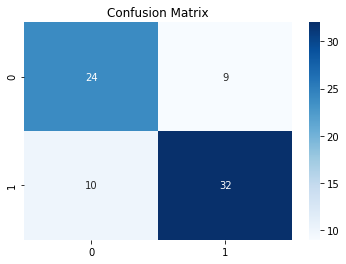



- ROC/AUC -



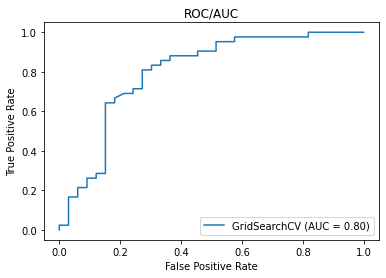



- Feature Importance -



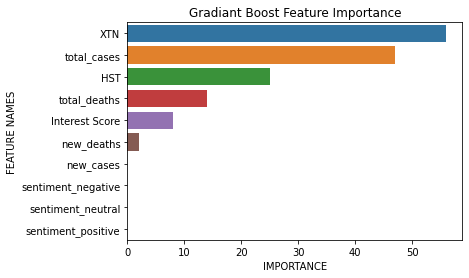

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

Classifier with best test set accuracy: Random Forest
CPU times: user 1min 34s, sys: 2.04 s, total: 1min 36s
Wall time: 13min 17s


In [231]:
%%time 
# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''

for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    
    # Fit grid search
    gs.fit(X_train, y_train)
    
    # Best params
    print('Best params: %s' % gs.best_params_)
    
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    print('\n\n- Classification Report -\n')
    
    # Print Classification report
    print(classification_report(y_test,y_pred))
    
    # Print Confusion Matrix
    print('\n\n- Confusion Matrix -\n')
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    plt.title(grid_dict[idx] + ' Confusion Matrix')
    plt.show()


    # Plot ROC curve
    print('\n\n- ROC/AUC -\n')
    plot_roc_curve(gs, X_test, y_test)
    plt.title(grid_dict[idx] + ' ROC/AUC')
    plt.show()
    
    # Feature importance
    if idx!=1:
        print('\n\n- Feature Importance -\n')
        model= gs.best_estimator_.named_steps['clf'] 
        plot_feature_importance(model.feature_importances_,X_test.columns, grid_dict[idx])
        plt.show()
        
    print('-*-'*30)
    
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx

print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

In [ ]:
#---------------EOF-----------------#